In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-09-15 11:19:34.149075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 11:19:34.149122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)

# homo_ = np.zeros(homo.shape)
# lumo_ = np.zeros(lumo.shape)

# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_[:,0] = np.add(homo[:,0],0)
#         homo_[:,1] = np.add(homo[:,1],i)
#         homo_[:,2] = np.add(homo[:,2],j)
#         homo_[:,3] = np.add(homo[:,3],0)
        
#         homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
#         homo_pairs[idx] = homo_pair_
        
#         lumo_[:,0] = np.add(lumo[:,0],0)
#         lumo_[:,1] = np.add(lumo[:,1],i)
#         lumo_[:,2] = np.add(lumo[:,2],j)
#         lumo_[:,3] = np.add(lumo[:,3],0)
        
#         lumo_pair_ = md.MO_pair_descriptor(lumo, lumo_).make()
#         lumo_pairs[idx] = lumo_pair_

# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('data/cdftcoupling.csv', delimiter=',')
c_dexter = np.array(raw_data[:,4])

In [4]:
mo_pairs = []
for ii, i in enumerate(homo_pairs):
    mo_pairs.append((homo_pairs[ii],lumo_pairs[ii]))
mo_pairs = np.array(mo_pairs)

train_mo_pairs = mo_pairs
train_c_dexter = -np.log(c_dexter)

In [5]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256,256), 'batch_size':1681, 'training_steps':200000,\
'learning_rate': 0.00001, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./save2',\
'seed':None, 'debug_traj': True}
NN = nn.NN(setting_dict=setting)
NN.train(train_mo_pairs,train_c_dexter)

2022-09-15 11:19:43.822015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-15 11:19:43.822076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-15 11:19:43.822111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Bai-Group): /proc/driver/nvidia/version does not exist
2022-09-15 11:19:43.823845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loss:  39.7090149
training step:     0
loss:  3.07838154
training step:  1000
loss:  1.21926045
training step:  2000
loss:  0.78811121
training step:  3000
loss:  0.572090089
training step:  4000
loss:  0.480240583
training step:  5000
loss:  0.416151464
training step:  6000
loss:  0.376663685
training step:  7000
loss:  0.333920032
training step:  8000
loss:  0.294292718
training step:  9000
loss:  0.259100109
training step: 10000
loss:  0.219147414
training step: 11000
loss:  0.176130861
training step: 12000
loss:  0.146329448
training step: 13000
loss:  0.120097578
training step: 14000
loss:  0.102580972
training step: 15000
loss:  0.0759141594
training step: 16000
loss:  0.062707454
training step: 17000
loss:  0.0534163192
training step: 18000
loss:  0.049268961
training step: 19000
loss:  0.0441662483
training step: 20000
loss:  0.0392167978
training step: 21000
loss:  0.0327843241
training step: 22000
loss:  0.0312579386
training step: 23000
loss:  0.0312624834
training step: 240

2022-09-15 12:57:59.983498: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./save2/model/assets


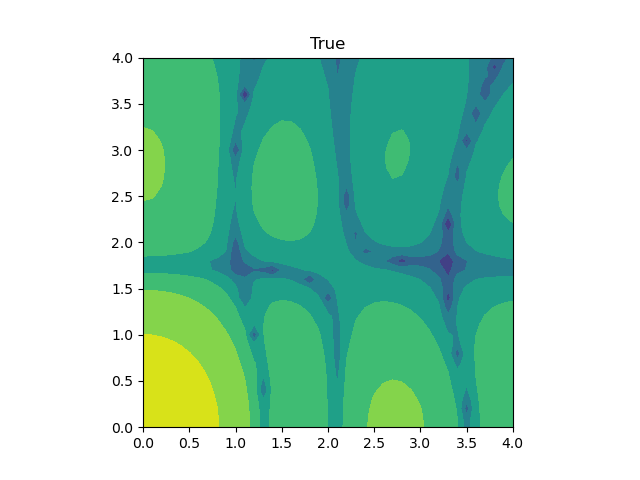

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
Z1 = c_dexter.reshape((41,41))

fix, ax = plt.subplots()
ax.contourf(x,y, np.log(Z1.T))
ax.set_title('True')
ax.set_aspect('equal')
plt.savefig('dexter_true.png')

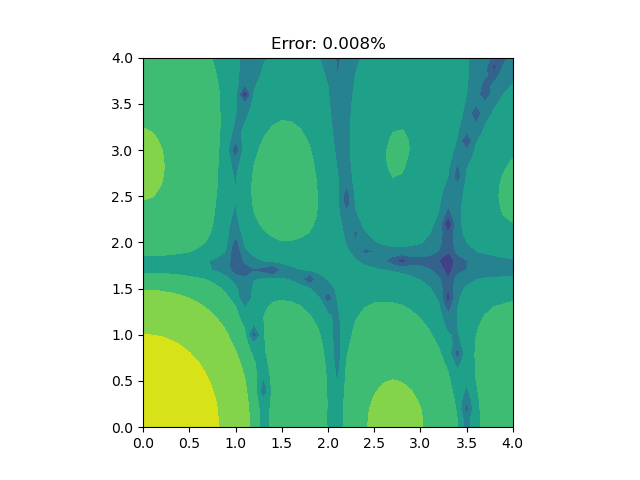

In [7]:
error = np.mean(np.multiply(NN.model(train_mo_pairs, training=False).numpy().reshape((1681,))-train_c_dexter, np.power(train_c_dexter,-1))*100)
Z = NN.model(train_mo_pairs, training=False).numpy().reshape((41,41))

fix, ax = plt.subplots()
ax.contourf(x,y, -Z.T)
ax.set_aspect('equal')
ax.set_title('Error: %5.3f%%'%error)
plt.savefig('dexter_pred.png')

In [8]:
print(Z1.T)

[[1.30743e-01 1.29124e-01 1.24354e-01 ... 4.86700e-03 5.89800e-03
  6.57200e-03]
 [1.29589e-01 1.27982e-01 1.23245e-01 ... 4.88000e-03 5.90300e-03
  6.57300e-03]
 [1.26180e-01 1.24607e-01 1.19977e-01 ... 4.91300e-03 5.91300e-03
  6.56500e-03]
 ...
 [7.41600e-03 7.31300e-03 7.00300e-03 ... 7.10000e-05 2.68000e-04
  4.39000e-04]
 [6.68000e-03 6.58800e-03 6.31500e-03 ... 1.50000e-05 1.58000e-04
  3.11000e-04]
 [5.96500e-03 5.88500e-03 5.64500e-03 ... 7.90000e-05 7.30000e-05
  2.08000e-04]]
